<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Continuity


> Samples are needed for sequence models and transformer models for input

😈 **Task 1:** Why might LSTM be more effective for time series than a feedforward model like MLP?

😈 **Question 1:** What types of patterns are LSTM models particularly good at capturing?



In [1]:
!pip install statsmodels tensorflow gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp"]

In [3]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [4]:
# Mount google drive when working in colab
hasCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if hasCOLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  BASEPATH = '/content/drive/MyDrive'
else:
  BASEPATH = '.'

Mounted at /content/drive


In [ ]:
import gdown

gdown.download(id="1XsCWRTpSZOBhZuL-a7OQ31PXa6ENvr1Q", output="X_test.pkl", quiet=True)
gdown.download(id="1OKQIVHf3d9TkdjJUaBu-PSe6FooJ6yhU", output="X_train.pkl", quiet=True)
gdown.download(id="1gs6gpCGocrob3il3gZgnKXFLm95r4Tyi", output="y_test.pkl", quiet=True)
gdown.download(id="1pW6wXMetnxr-eh0QhYr2O73b00jSVHaz", output="y_train.pkl", quiet=True)

'y_train.pkl'

In [6]:
from re import X
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing
TIMESERIES_DATA_DIR = "/content/drive/MyDrive/timeseries_data/"
with open("/content/drive/MyDrive/timeseries_data/X_train.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("/content/drive/MyDrive/timeseries_data/X_test.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("/content/drive/MyDrive/timeseries_data/y_train.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("/content/drive/MyDrive/timeseries_data/y_test.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

## Raw data csv is also made available for the select stations in URL:
#url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
#dataframe = pd.read_csv(url,parse_dates=["datetime"])
## Else if using local files:
dataframe = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "raw_data.csv"))
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}

X_train = X_train_full[:,:,len(variable_column)].copy()
X_test = X_test_full[:,:,len(variable_column)].copy()
y_train = y_train_full[:,:,len(variable_column)].copy()
y_test = y_test_full[:,:,len(variable_column)].copy()

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(variable_column))
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(variable_column))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(variable_column))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(variable_column))

X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(dataframe['temp'].mean(), dataframe['temp'].std())

X_train_full shape: (180292, 336, 2), y_train_full shape: (180292, 96, 2)
X_test_full shape: (77269, 336, 2), y_test_full shape: (77269, 96, 2)
X_train shape: (180292, 336, 1), y_train shape: (180292, 96, 1)
X_test shape: (77269, 336, 1), y_test shape: (77269, 96, 1)
10.730136547182456 7.789657528725868


### Forecasting with Recurrent NN : LSTM

> LSTM multi step ahead and one step ahead predictions

😈 **Task 2:** Compare LSTM results with previous MLP results. What differences do you observe in performance and loss curves?

😈 **Task 3:** Visualize hidden states or prediction errors over time.

In [7]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_column)
# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(variable_column)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_column)))

#### Multi Step ahead prediction

> Loss accumulation is expected when you do a multi step ahead prediction via LSTM or any sequential model. Due to error propagation, uncertainty growth, data distribution shift. However techniques like scheduled sampling, teacher forcing, and attention mechanisms (as we will illustrate below in transformer architecture) can be used for improvements


😈 **Question 2:** Why does error accumulate in multi-step forecasting?

😈 **Task 4:** Implement scheduled sampling or try a basic attention layer in your LSTM.

In [8]:
!mkdir -p checkpoint

!gdown --folder https://drive.google.com/drive/folders/1svSuEHTDMrkL_CrHqYHgtp2ZuWOuFTXS -O checkpoint

Retrieving folder contents
Processing file 1Wn71xbqSBIRnMzys3uL8WwXwxGkG7yvJ lstm_var0.h5
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Wn71xbqSBIRnMzys3uL8WwXwxGkG7yvJ
To: /content/checkpoint/lstm_var0.h5
100% 465k/465k [00:00<00:00, 128MB/s]
Download completed


In [9]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/1svSuEHTDMrkL_CrHqYHgtp2ZuWOuFTXS?usp=drive_link
# and the path needs to be updated to checkpoint_dir below to local downloaded path:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_column):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_column)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, :, var_idx].reshape(y_train.shape[0], -1)

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(prediction_horizon)
        ])

        lstm_model.compile(optimizer="adam", loss="mse")

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single,
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model

lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)


# Evaluate and denormalizing
for var_idx, col in enumerate(variable_column):
    print(f"Predicting for {col}...")

    # X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    X_test_sample=X_test_full[X_first_idx, :, var_idx+1].reshape(1,context_window,1).astype(np.float32) # First column is station code hence adding 1

    lstm_pred_single = lstm_model.predict(X_test_sample)
    lstm_predictions[:, :, var_idx] = lstm_pred_single

    lstm_predictions[:, :, var_idx] = (
        lstm_predictions[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, :, var_idx] = (
        y_test[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )


Training LSTM for variable 1/1: temp
Loading existing model for variable temp


Predicting for temp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


In [10]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[:, :, var_idx]
    y_pred_single = lstm_predictions[:, :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 9.2363


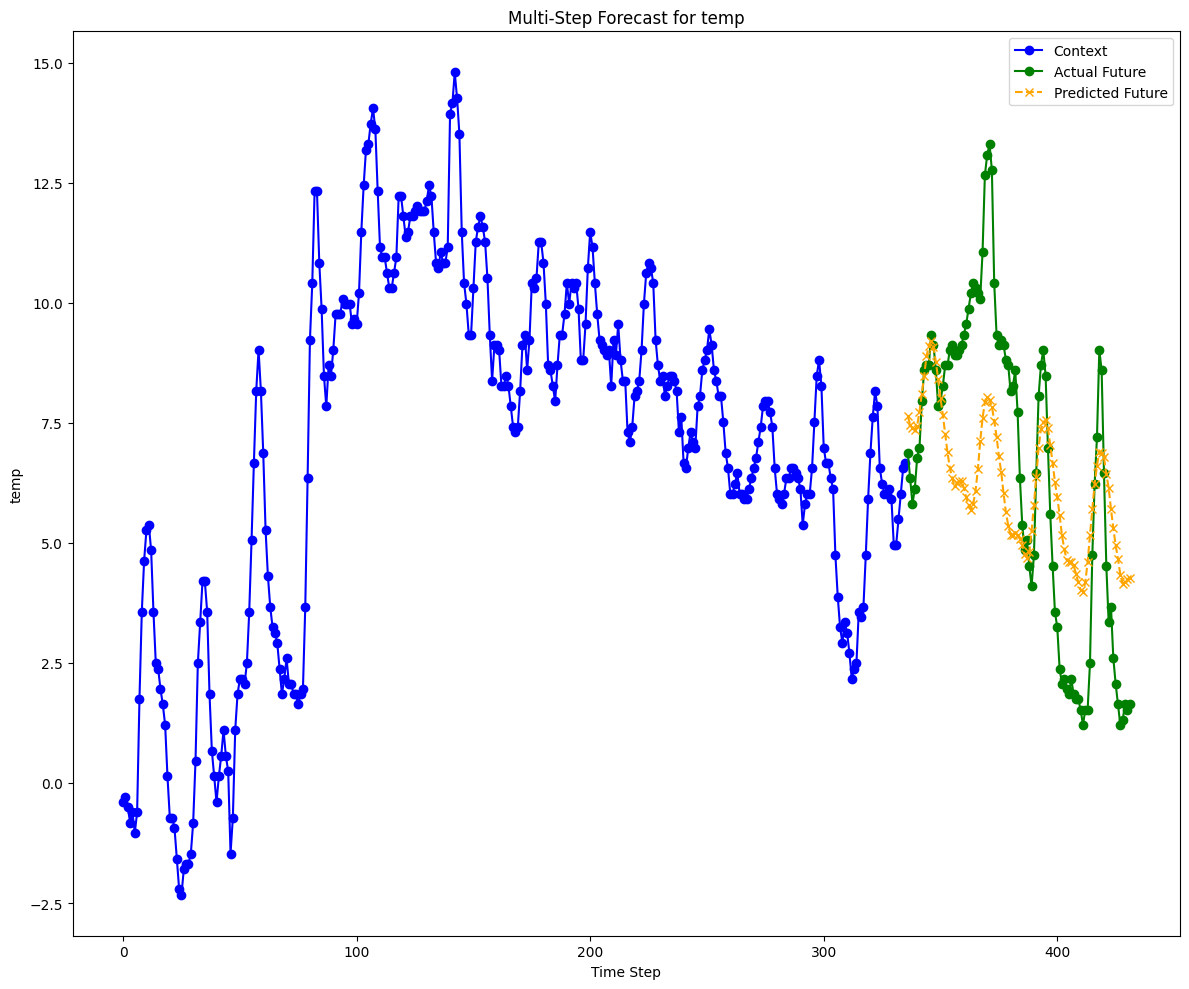

In [11]:
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    # # Extract data for the last sample
    # context = X_test[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    # actual_future = y_test_actual[-1, :, var_idx] #actual and pred denormalized in prev cell
    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    context=X_test_full[X_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    actual_future=y_test_full[y_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1

    predicted_future = lstm_predictions[-1, :, var_idx] #actual and pred denormalized in prev cell

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        actual_future,
        label="Actual Future",
        color="green",
        marker="o"
    )

    # Plot predicted future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        predicted_future,
        label="Predicted Future",
        color="orange",
        linestyle="--",
        marker="x"
    )

    plt.title(f"Multi-Step Forecast for {col}")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


#### One Step ahead prediction

😈 **Task 5:** Train both one-step and multi-step models on the same dataset and compare RMSE.

😈 **Question 3:** In what real-world scenario would one-step prediction be more useful than multi-step?


In [12]:
!mkdir -p checkpoint

!gdown --folder https://drive.google.com/drive/folders/11xQT7xvmA5Pj9VKck3C4wTOEUvX2gnIJ -O checkpoint

Retrieving folder contents
Processing file 1BXC__wuWz7n2ww3IEDaAarvcL5oDaoNw lstm_one_step_var0.h5
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1BXC__wuWz7n2ww3IEDaAarvcL5oDaoNw
To: /content/checkpoint/lstm_one_step_var0.h5
100% 407k/407k [00:00<00:00, 99.2MB/s]
Download completed


In [21]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/11xQT7xvmA5Pj9VKck3C4wTOEUvX2gnIJ?usp=drive_link
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_column):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_column)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, 0, var_idx]

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_one_step_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(1)
        ])

        lstm_model.compile(optimizer=lstm_optim, loss=lstm_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single.reshape(-1, 1),
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model
lstm_predictions = np.zeros((y_test.shape[0], len(variable_column)))
y_test_actual = np.zeros((y_test.shape[0], len(variable_column)))


# Predict
for var_idx, col in enumerate(variable_column):
    print(f"Predicting for {col}...")

    # X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    X_test_sample=X_test_full[X_first_idx, :, var_idx+1].reshape(1,context_window,1).astype(np.float32) # First column is station code hence adding 1


    lstm_pred_single = lstm_model.predict(X_test_sample).flatten()
    lstm_predictions[:, var_idx] = lstm_pred_single

    # Inverse transform predictions and actual values
    lstm_predictions[:, var_idx] = (
        lstm_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[:, 0, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )



Training LSTM for variable 1/1: temp
Loading existing model for variable temp
Predicting for temp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


In [22]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[ :, var_idx]
    y_pred_single = lstm_predictions[ :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 8.8694


In [23]:
lstm_ms_results = pd.DataFrame({
    "timestep": range(context_window, context_window + prediction_horizon),
    "value": predicted_future
})
lstm_ms_results.to_csv("/content/drive/MyDrive/timeseries_data/lstm_multistep_results.csv", index = False)

In [15]:
lstm_rolling_predictions = np.zeros((prediction_horizon, len(variable_column)))
y_test_actual = np.zeros((prediction_horizon, len(variable_column)))

# Select the last sample from the test set
X_test_single = X_test_lstm[-1]

for var_idx, col in enumerate(variable_column):
    # X_test_var = X_test_single[:, var_idx].reshape(1, context_window, 1)

    for step in range(prediction_horizon):
        lstm_pred_single = lstm_models[col].predict(X_test_sample)

        lstm_rolling_predictions[step, var_idx] = lstm_pred_single[0, 0]

        # Shift the window and append the new prediction
        X_test_sample = np.roll(X_test_sample, shift=-1, axis=1)
        X_test_sample[0, -1, 0] = lstm_pred_single

    # Inverse scale the predictions and actual values for the current variable
    lstm_rolling_predictions[:, var_idx] = (
        lstm_rolling_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[-1, :prediction_horizon, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/tmp/ipython-input-15-1061164367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test_sample[0, -1, 0] = lstm_pred_single


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

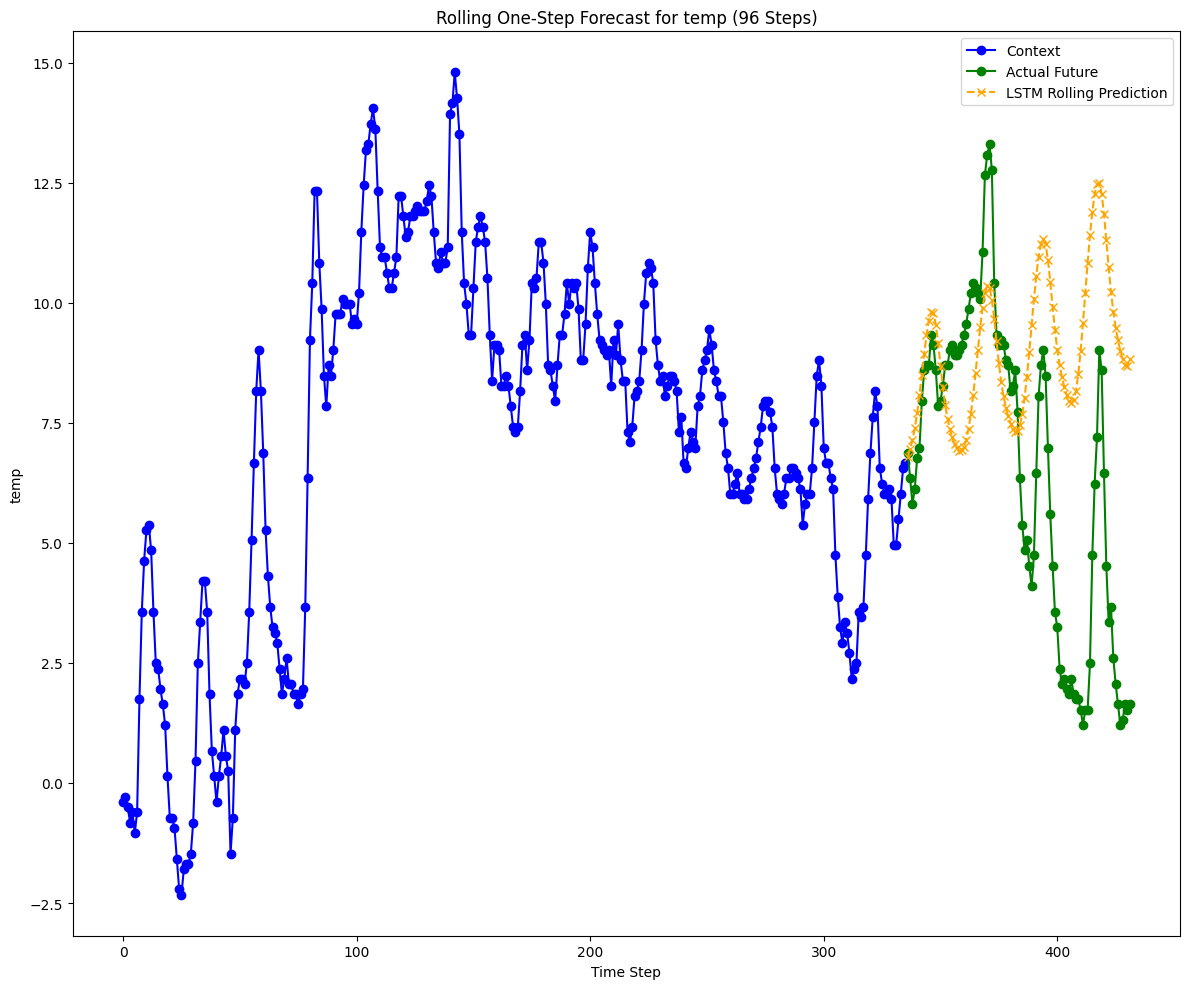

In [16]:
# Plot Rolling One-Step-Ahead Forecast for All Variables (for the last sample)
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    context=X_test_full[X_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    actual_future=y_test_full[y_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1

    predicted_future = lstm_rolling_predictions[:, var_idx] #actual and pred denormalized in prev cell

    # Plot context window
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), actual_future,
             label="Actual Future", color="green", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future,
             label="LSTM Rolling Prediction", color="orange", linestyle="--", marker="x")

    plt.title(f"Rolling One-Step Forecast for {col} ({prediction_horizon} Steps)")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

In [20]:
lstm_os_results = pd.DataFrame({
    "timestep": range(context_window, context_window + prediction_horizon),
    "value": predicted_future
})
lstm_os_results.to_csv("/content/drive/MyDrive/timeseries_data/lstm_onestep_results.csv", index = False)